# Federal Contractors and Campaign Contributions Cross-reference Notebook



### The objective of this notebook is to provide a cross-reference research tool  
- Facilitate full text search across two open data systems USASpending and FEC 
providing the ability to cross reference data from both systems related to
 federal contractor campaign contributions.

- The data returned from each system provides an internal id or url for validation of 
results.
- ***Any results can and should be validated in the source systems.***

- This notebook uses full text search api endpoints provided by USA Spending and FEC.
  - https://api.usaspending.gov/api/v2/search/spending_by_award/
  - https://api.open.fec.gov/v1/schedules/schedule_a/efile/
  - Api documentation and code is available at github.
    -  https://github.com/fedspendingtransparency/usaspending-api/blob/master/usaspending_api/api_contracts/contracts/v2/search/spending_by_award.md
    - https://github.com/fecgov/openFEC/blob/8b937955a902152b00e649e234e1854d3ee0ba1f/webservices/resources/sched_a.py#L155
- The data is publicly available from:
  - https://www.usaspending.gov/
  - https://www.fec.gov/
- Results are limited by contractor name, date range, and donation amount parameters.
- It is recommended that users will obtain an api key but this is not necessary.
  - ```DEMO_KEY``` is a valid test key. 
  - https://api.open.fec.gov/developers
- The notebook can be run with Jupyter Notebook, VSCode, or the users preferred IDE.
- Python/Jupyter install instruction video for Mac
  - https://www.youtube.com/watch?v=AX40aqRVlAw
- Python/Jupyter install instruction video for Windows
  - https://www.youtube.com/watch?v=BFTEA9Jt7hI

### Note this code is not designed to support high volume searching of many entities.
- If the goal is searching for many entities a different approach will be needed.
- API rate throttling can occur, if you see a message for connection closed, this is probably the case.
  - ```ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))```
  - The code will be updated to handle these cases when time permits.

- There is no warranty or guarantee of accuracy, as a user of this code you agree to these terms.
- The code is a work in progress and will be changed as needed.
- Created by Damien Johnston 11/14/2024
- Host repo: https://github.com/damien-johnston/open-data-project
- Please use the host repo for any comments, questions, or issues. 

# Installations and Dependencies

In [1]:
# Installs and Import Dependencies
# Install for Notebook
#%pip install requests
#%pip install jinja2

import requests
import pandas as pd
from IPython.display import display, HTML
import plotnine as p9
from plotnine import scale_y_continuous
import matplotlib.ticker as mticker

# Functions


 
## Function for contractor details from USASpending.gov
- Note this function limits pagination to 3 pages, if more data is needed this parameter will need to be changed.
- API rate throttling logic will be needed to handle rate limits.

In [2]:
# Function to retrieve contractor data from 'https://api.usaspending.gov/api/v2/search/spending_by_award/'
def get_contractors(
    recipient_search_text=["Coinbase"],
    start_date="2024-01-01",
    end_date="2024-12-31",
    api_key=None,
):
    """
    Fetches contractor data from USASpending API.

    Parameters:
    recipient_search_text (list): List of recipient names to search for. Defaults to an empty list.

    Endpoint documentation:
    https://github.com/fedspendingtransparency/usaspending-api/blob/master/usaspending_api/api_contracts/contracts/v2/search/spending_by_award.md
    """

    # API Endpoint
    BASE_URL = "https://api.usaspending.gov/api/v2/search/spending_by_award/"

    # Headers
    headers = {
        "Content-Type": "application/json"
    }

    # Add api_key to headers if provided
    if api_key:
        headers["X-API-Key"] = api_key

    # Payload to search for contract awards
    payload = {
        "filters": {
            "other_financial_assistance": ["06", "10"],
            "direct_payments": ["09", "11", "-1"],
            "loans": ["07", "08"],
            "idvs": [
                "IDV_A",
                "IDV_B",
                "IDV_B_A",
                "IDV_B_B",
                "IDV_B_C",
                "IDV_C",
                "IDV_D",
                "IDV_E",
            ],
            "grants": ["02", "03", "04", "05"],
            "award_type_codes": ["A", "B", "C", "D"],
            "time_period": [{"start_date": start_date, "end_date": end_date}],
        },
        "fields": [
            "Award ID",
            "Recipient Name",
            "Start Date",
            "End Date",
            "Award Amount",
            "Awarding Agency",
            "Awarding Sub Agency",
            "Contract Award Type",
            "Award Type",
            "Funding Agency",
            "Funding Sub Agency",
        ],
        "limit": 100,
        "page": 1,
    }

    # Set the recipient_search_text if provided
    if recipient_search_text:
        payload["filters"]["recipient_search_text"] = recipient_search_text

    all_data = []  # List to store all the results
    page = 1  # Initialize the page number

    # Continue requests until there are no more pages
    while page <= 3:

        payload["page"] = page
        response = requests.post(BASE_URL, headers=headers, json=payload)

        if response.status_code == 200:
            data = response.json()
            results = data.get("results", [])

            # Break the loop if no more results
            if not results:
                break

            all_data.extend(results)
            
            page += 1  # Go to the next page

        else:
            print(f"Error: {response.status_code}, {response.text}")
            break

    # Assign list to DataFrame
    df = pd.DataFrame(all_data)

    if "generated_internal_id" in df.columns:
        columns = ["generated_internal_id"] + [
            col for col in df.columns if col != "generated_internal_id"
        ]
        contractor_awards = df[columns]
        return contractor_awards

## Function for federal contractor contributions from FEC.gov 
- If no contributions are found the function will print a message.
- Note this function limits pagination to 10 pages, if more data is needed this parameter will need to be changed.
- API rate throttling logic will be needed to handle rate limits.

In [28]:
# Get contributions by contractor name using api 'https://api.open.fec.gov/v1/schedules/schedule_a/efile/'
def fetch_contributions(
    contributor_name=["Coinbase"],
    min_date="2024-01-01",
    max_date="2024-12-31",
    min_amount=10000,
    api_key=None,
):
    """
    Fetches contribution data from the FEC API.

    Parameters:
    contributor_name (list): List of contributor names to search for. Defaults to an empty list.

    Returns:
    pd.DataFrame: DataFrame containing contribution details.
    """

    # API Endpoint
    url = "https://api.open.fec.gov/v1/schedules/schedule_a/efile/"

    # Parameters for the API call
    params = {
        "per_page": 100,
        "page": 1,
        "sort": "contribution_receipt_date",
        "min_amount": 10000,
        "min_date": min_date,
        "max_date": max_date,
    }

    # Add api_key to params if provided
    if api_key:
        params["api_key"] = api_key

    # Add contributor_name filter if provided
    if contributor_name:
        params["contributor_name"] = contributor_name

    all_data = []  # List to store all the results
    page = 1  # Initialize the page number

    # Use pagination to request data
    while page <= 10:
        params["page"] = page
        
        # Make the request
        response = requests.get(url, params=params)

        # Set the max column width to None to display full URL for reference.
        pd.set_option("display.max_colwidth", None)

        if response.status_code == 200:
            data = response.json()
            results = data.get("results", [])

            # Break the loop if no more results
            if not results:
                break

            all_data.extend(results)
            
            page += 1  # Go to the next page

        else:
            print(f"Error: {response.status_code}, {response.text}")
            break

    contributions_df = pd.DataFrame(all_data)

    if "committee" in contributions_df.columns:
        contributions_df["committee_name"] = contributions_df["committee"].apply(
            lambda x: x.get("name", "N/A") if isinstance(x, dict) else "N/A"
        )
    else:
        contributions_df["committee_name"] = "N/A"

    # Move pdf_url to front of dataframe and convert to hyperlink 
    if not contributions_df.empty:
        # Move pdf_url to the first column
        columns = ["pdf_url"] + [
            col for col in contributions_df.columns if col != "pdf_url"
        ]
        contributions_df = contributions_df[columns]
        contributions_df = contributions_df.loc[:, contributions_df.columns != "committee"]
        contributions_df = contributions_df.loc[:, contributions_df.columns != "filing"]
        
        # Display with pdf_url as a clickable link
        contributions_df.style.format(
            {"pdf_url": lambda x: f'<a href="{x}" target="_blank">{x}</a>'}
        )
    else:
        print(
            f"The DataFrame is empty no contributions were found during the search for {contributor_name}"
        )

    return contributions_df

# Parameters


## Parameter Documentation



### Contractors is a list of (strings), the code supports a single name at this point.
- ```contractors = ['FORD MOTOR COMPANY']```
- Note, this parameter is used to filter by full text search endpoints.
- It is not an exact match.
- e.g. searching for ```'Meta'``` will return results for ```'Metal'```
- In these cases search for a more defined name like ```'Meta Platforms'```

### Date range parameters (string) define a window of time for a search.
- Date From is the minimum date for contractors and contributions.
    - ```date_from = "2024-01-01"```
- Date To is the maximum date to end searching for contractors and contributions.
    - ```date_to = "2024-12-31"```

### Contribution Minimum Amount (number)
- ```contribution_min_amount = 10000```

### API Key (string)
- If api_key is not in use comment out the key parameter.
- API rate limits are lower without a key.
- ```api_key = 'YourKeyGoesHere'```

### Processing Control Parameters
- Show DataFrame (boolean)
    - Used to control processing and show DataFrame output from functions.
    - ```show_dataframe = True``` 
- Show Visualization (boolean)
    - Used to control processing and show Visualizations.
    - ```show_visualization = True```
- Show Visualizations Amount Labels 
    - ```show_visualization_amount_labels = True```

#### Note, the functions in use have default parameters defined, if none are assigned
- ```contractors = "Coinbase"```
- ```date_from = "2024-01-01"```
- ```date_to = "2024-12-31"``` 
- ```contribution_min_amount = 10000```
- ```show_dataframe = True```
- ```show_visualization = True```
- ```show_visualization_amount_labels = True```

## Parameter Values

In [48]:
# Filter variables
contractors = ['Coinbase']
date_from = "2024-01-01" 
date_to = "2024-12-31" 
contribution_min_amount = 10000

# Your API Key
api_key = 'DEMO_KEY'

# Processing control variables
show_dataframe = True
show_visualization = True
show_visualization_amount_labels = True

#  Contractor and Contributions Data

## Contractor Awards
- Internal IDs can be used for validation at source systems.

In [49]:
# If show_dataframe is true display data
gc = pd.DataFrame()

if show_dataframe:
    gc = get_contractors(contractors, date_from, date_to, api_key)
    display(gc) 

,generated_internal_id,internal_id,Award ID,Recipient Name,Start Date,End Date,Award Amount,Awarding Agency,Awarding Sub Agency,Contract Award Type,Award Type,Funding Agency,Funding Sub Agency,awarding_agency_id,agency_slug
0,CONT_AWD_15M50024FA4400016_1544_15M50024DA4400010_1544,172644615,15M50024FA4400016,COINBASE INC,2024-07-01,2025-06-30,6978346.66,Department of Justice,U.S. Marshals Service,DELIVERY ORDER,None,Department of Justice,U.S. Marshals Service,252,department-of-justice


## Contributions DataFrame 
- PDF_URL can be used for validation at source system.

In [51]:
# If show_dataframe is true display data
if show_dataframe:
    contractor_contributions_df = fetch_contributions(
        contractors, date_from, date_to, contribution_min_amount, api_key
    )
    
contractor_contributions_df.head()

,pdf_url,amendment_indicator,back_reference_schedule_name,back_reference_transaction_id,committee_id,conduit_committee_city,conduit_committee_id,conduit_committee_name,conduit_committee_state,conduit_committee_street1,...,image_number,line_number,load_timestamp,memo_code,memo_text,pgo,related_line_number,report_type,transaction_id,committee_name
0,https://docquery.fec.gov/cgi-bin/fecimg/?202407209661447526,A,None,None,C00835959,None,None,None,None,None,...,202407209661447526,17,2024-07-20T11:53:47,X,None,None,9,F3XN,V25A794FF57FD6177096,FAIRSHAKE
1,https://docquery.fec.gov/cgi-bin/fecimg/?202407209661447526,A,None,None,C00835959,None,None,None,None,None,...,202407209661447526,17,2024-07-20T11:53:47,None,None,None,7,F3XN,A29772A492544D47927B,FAIRSHAKE
2,https://docquery.fec.gov/cgi-bin/fecimg/?202407199661408722,A,None,None,C00854299,None,None,None,None,None,...,202407199661408722,11AI,2024-07-19T17:59:15,None,None,None,4,F3XN,3728873,BOLD AMERICA
3,https://docquery.fec.gov/cgi-bin/fecimg/?202407159660900569,A,None,None,C00844530,None,None,None,None,None,...,202407159660900569,17,2024-07-15T20:45:16,None,Non-contribution account,None,35,F3XN,6284179,ROLLING SEA ACTION FUND
4,https://docquery.fec.gov/cgi-bin/fecimg/?202410189698660598,N,None,None,C00838862,None,None,None,None,None,...,202410189698660598,14A,2024-10-18T14:16:55,None,None,None,149,F4A,4249279,DEVELOPMENT NOW FOR CHICAGO


# Visualizations

## Visualizations for contractor awards by Funding Sub Agency

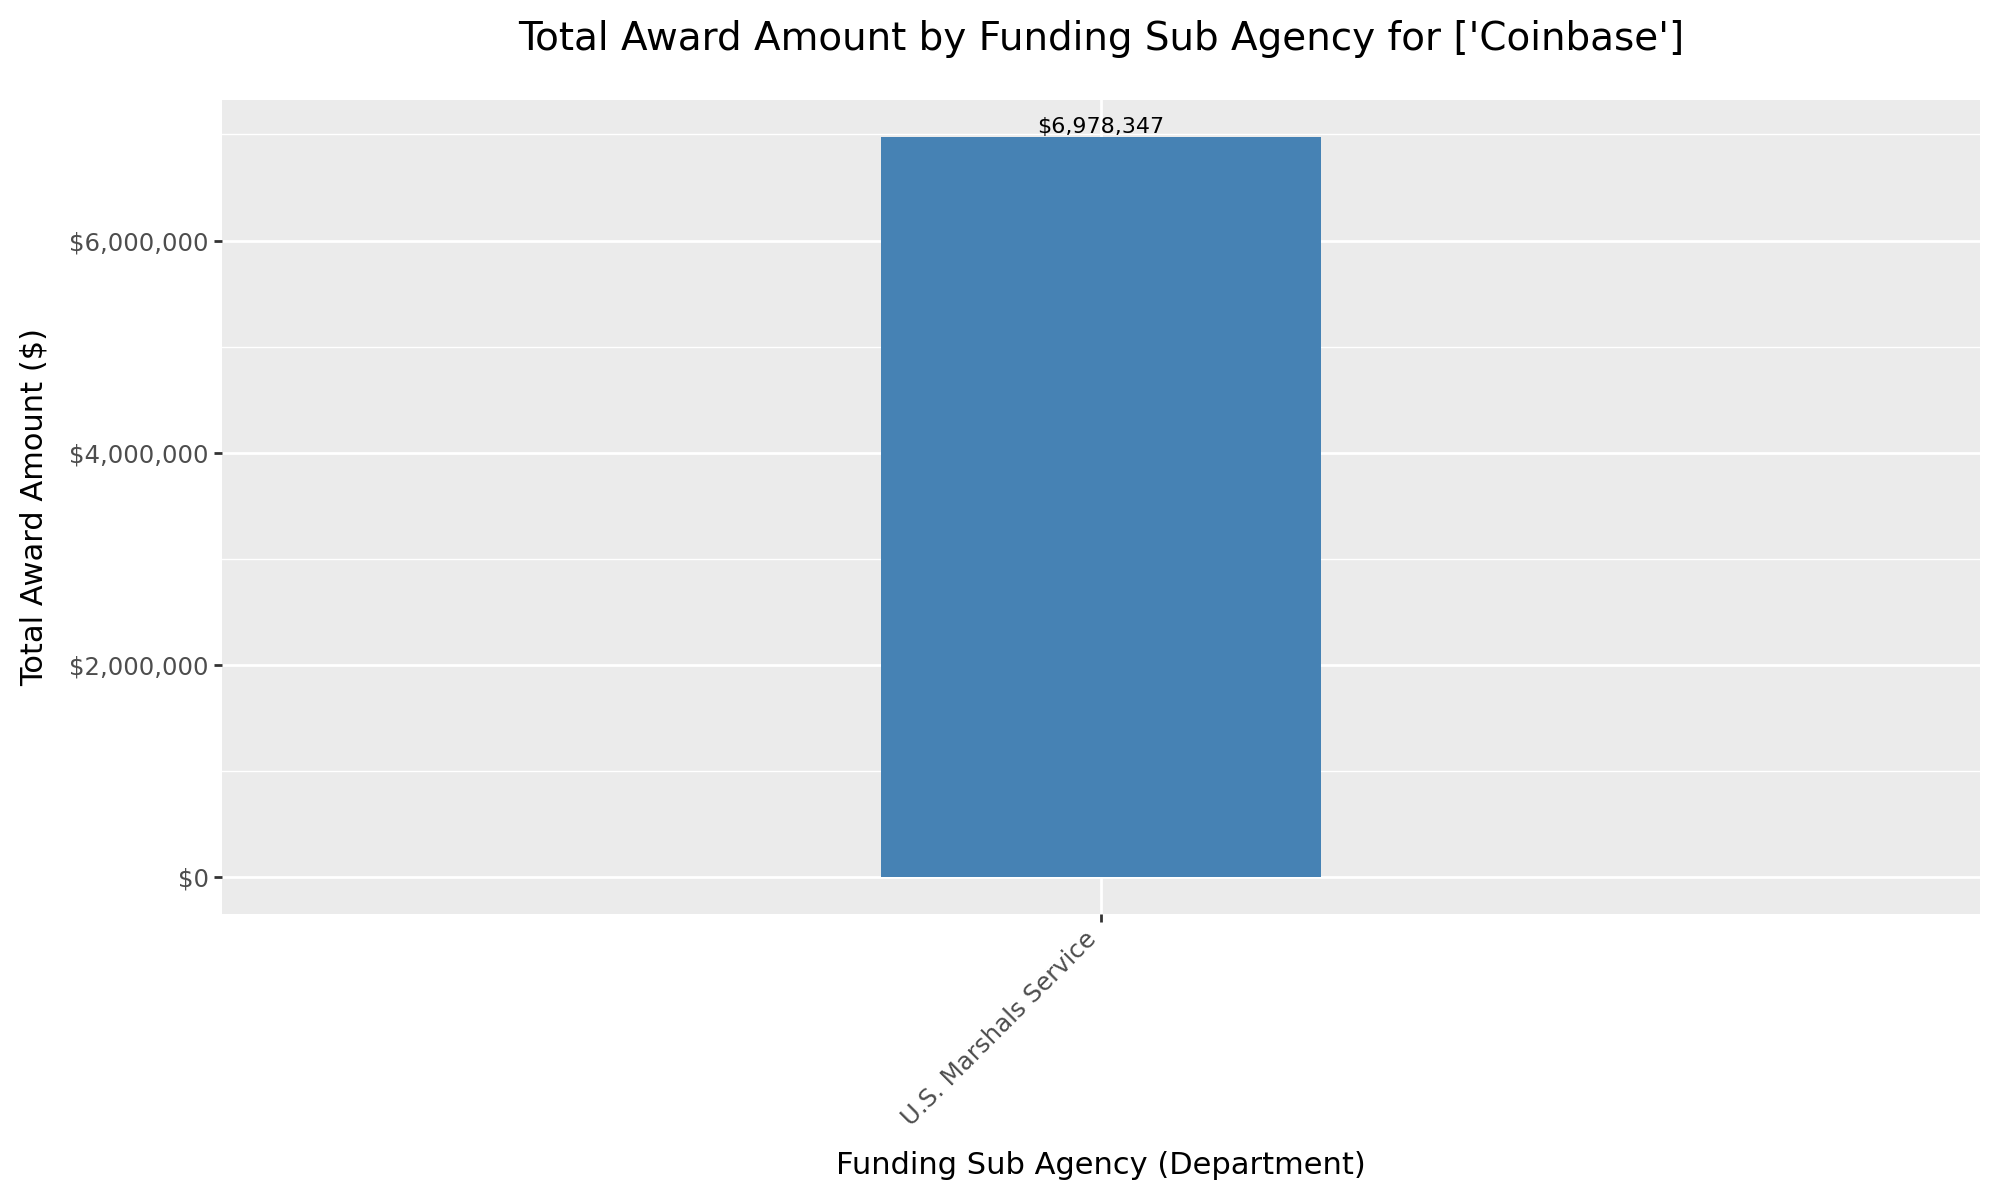

In [52]:
# Visualize contractor awards summed by department
if show_visualization:
    # Call the function to get contractor data
    df = get_contractors(
        contractors, date_from, date_to, api_key
    )

    # Ensure the 'Award Amount' is numeric, converting to float if necessary
    df["Award Amount"] = pd.to_numeric(df["Award Amount"], errors="coerce")

    # Group by Awarding Agency and sum the Award Amount
    agg_df = df.groupby("Funding Sub Agency", as_index=False)["Award Amount"].sum()

    # Plotting contract award data
    plot = (
        p9.ggplot(agg_df, p9.aes(x="Funding Sub Agency", y="Award Amount"))
        + p9.geom_bar(stat="identity", fill="steelblue", width=0.25)  # Adjust the bar width here
        + p9.ggtitle(f"Total Award Amount by Funding Sub Agency for {contractors}")
        + p9.xlab("Funding Sub Agency (Department)")
        + p9.ylab("Total Award Amount ($)")
        + p9.theme(
            axis_text_x=p9.element_text(rotation=45, hjust=1),
            figure_size=(10, 6),  # Adjust the size of the plot
            plot_title=p9.element_text(size=14, ha='center', margin={'b': 15})  # Adjust title                  
        )
        + p9.scale_y_continuous(labels=lambda l: [f"${int(x):,}" for x in l])
    )

    # Add data labels on top of the bars
    if show_visualization_amount_labels:
        plot += p9.geom_text(p9.aes(label=agg_df['Award Amount'].apply(lambda x: f'${x:,.0f}')),
        va='bottom', color='black', size=8)

    # Show the plot
    plot.show()

## Contributions Visualizations

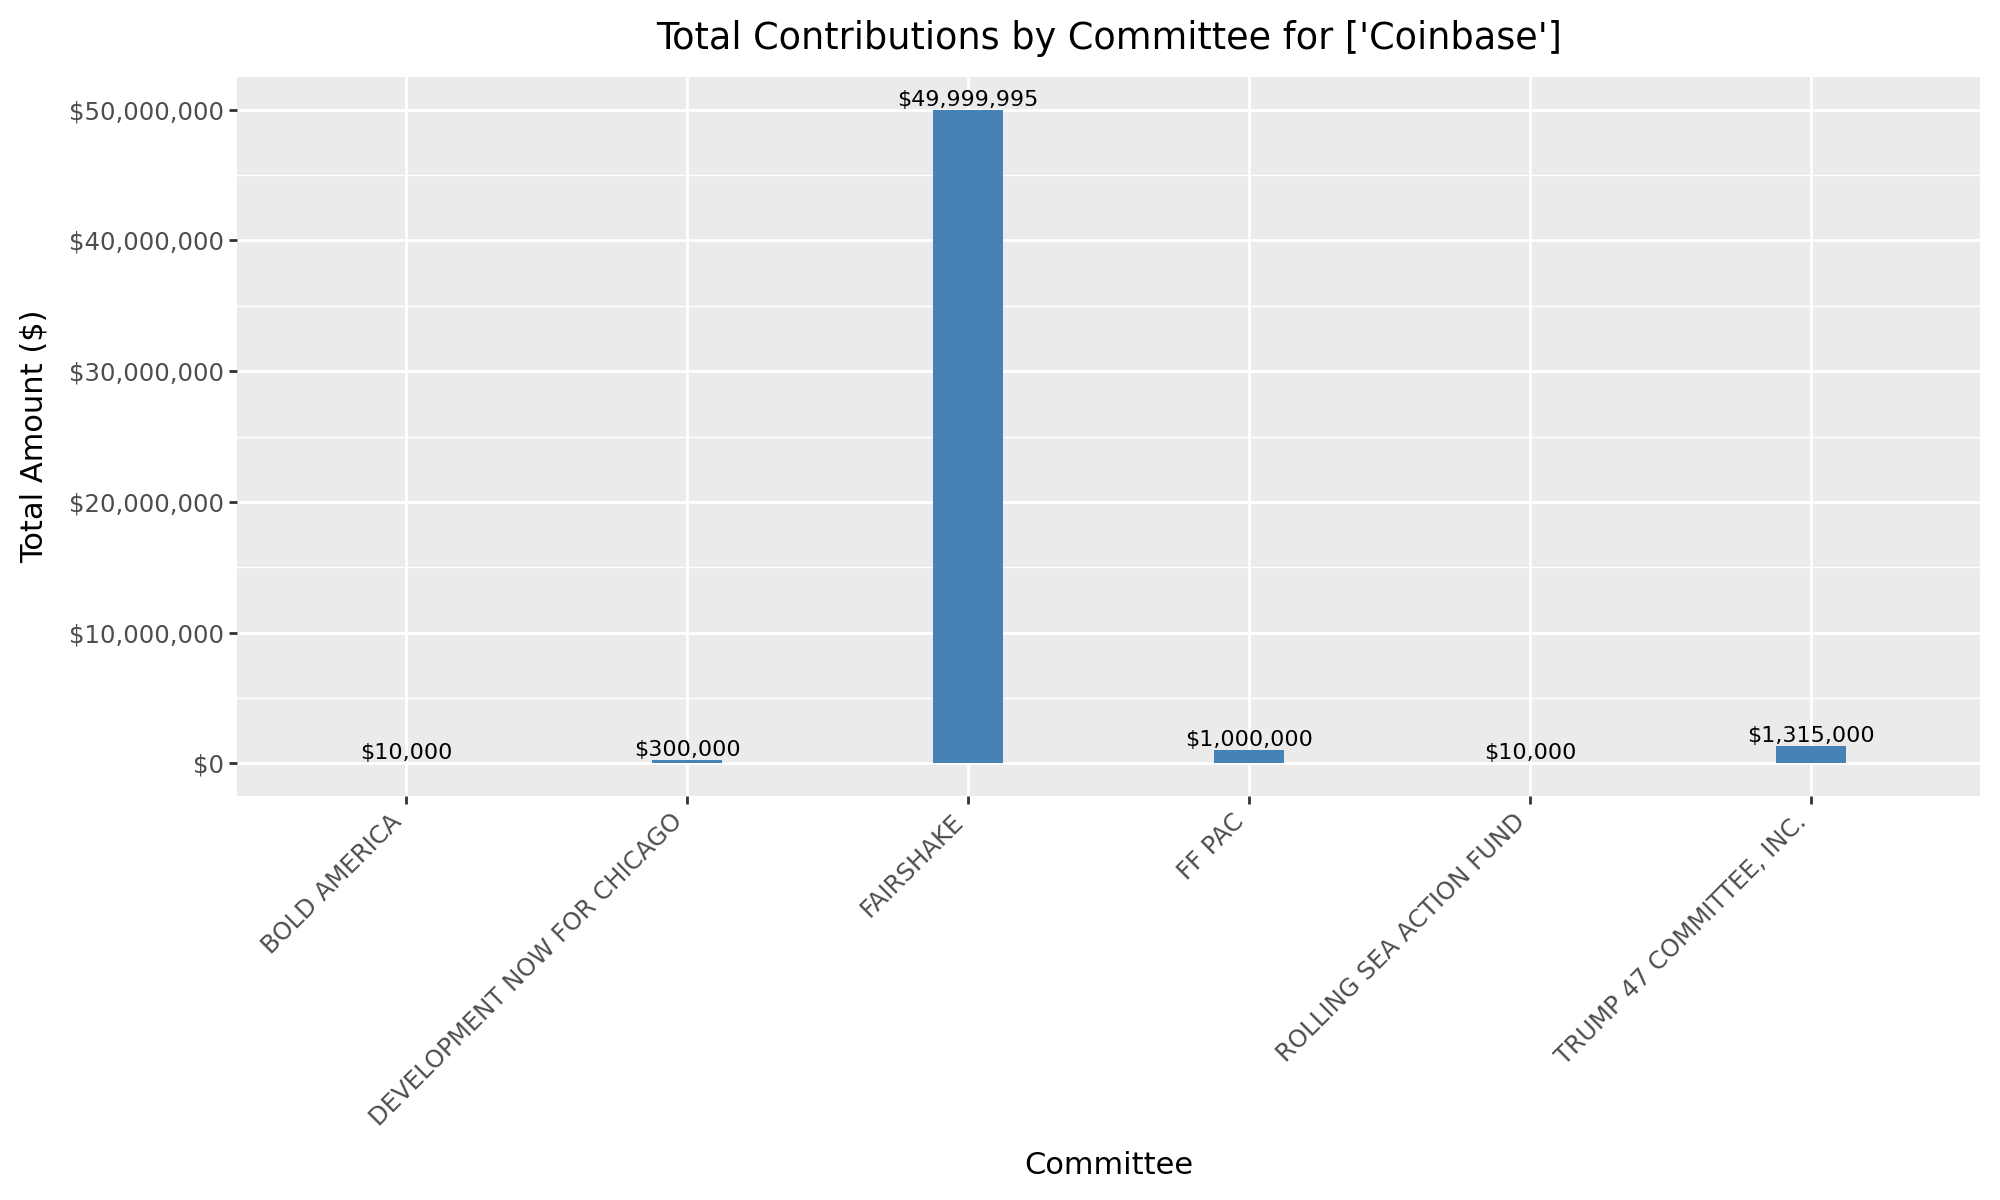

In [53]:
# Visualize the contribution data by a contractor
if show_visualization:
    contributions_df = fetch_contributions(contractors, date_from, date_to, contribution_min_amount, api_key)
    if not contributions_df.empty:
        # Aggregate contributions by committee
        agg_df = contributions_df.groupby(['committee_name'], as_index=False)['contribution_receipt_amount'].sum()

        # Rename columns for clarity
        agg_df.columns = ['Committee', 'Total Amount']

        # Assuming the previous code for fetching and aggregating data remains the same

        # Plotting
        plot = (
            p9.ggplot(agg_df, p9.aes(x='Committee', y='Total Amount')) +
            p9.geom_bar(stat='identity', fill='steelblue', width=0.25) +  # Adjust the bar width here +
            p9.ggtitle(f'Total Contributions by Committee for {contractors}') +
            #p9.ggtitle('Total Contributions by Committee') +
            p9.xlab('Committee') +
            p9.ylab('Total Amount ($)') +
            p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1),figure_size = (10, 6)) +
            p9.scale_y_continuous(labels=lambda l: [f'${int(x):,}' for x in l])
        )

        # Add data labels on top of the bars
        if show_visualization_amount_labels:
            plot += p9.geom_text(p9.aes(label=agg_df['Total Amount'].apply(lambda x: f'${x:,.0f}')),
                                va='bottom', color='black', size=8)

        # Show the plot
        plot.show()
    else:
        print(f"The DataFrame is empty no contributions were found during the search for {contractors}")